In [1]:
# !pip install wordcloud
# !pip install pandarallel
# !pip install contractions
# !pip install --upgrade pip
# !pip install --upgrade azure-cognitiveservices-language-textanalytics

In [1]:
import re
import json
import math
import nltk
import keys
import requests
import numpy as np
import contractions
import pandas as pd

from datetime import datetime
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import TweetTokenizer
from pandarallel import pandarallel
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.language.textanalytics import TextAnalyticsClient

#from keys import subscription_key, text_analytics_base_url, bing_spell_check_key, spell_check_url 

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
raw_tweets = pd.read_csv(
    "sample_tweets.csv",
    index_col=None
)

In [4]:
raw_tweets["id"] = raw_tweets.index
raw_tweets.rename(columns={"Body text": "text"}, inplace=True)
raw_tweets.head(2)

,Down ID,Posted time,text,Point latitiude,Point longitude,Bio location,Image url,id
0,"""tag:search.twitter.com,2005:1109081183105835008""",22/03/2019 13:15,"""Primeape was recently spotted trying to make ...",NaN,NaN,NaN,"""https://pbs.twimg.com/profile_images/76017773...",0
1,"""tag:search.twitter.com,2005:1109080961277407234""",22/03/2019 13:14,"""@gianninewbon Meet me at London Bridge at hal...",NaN,NaN,"""Derbados""","""https://pbs.twimg.com/profile_images/10569615...",1


In [5]:
raw_tweets.count()

Down ID            44816
Posted time        44816
text               44816
Point latitiude      701
Point longitude      701
Bio location       31946
Image url          42978
id                 44816
dtype: int64

In [6]:
# ~51% duplicates
raw_tweets.drop_duplicates(subset=['text']).count()

Down ID            22022
Posted time        22022
text               22022
Point latitiude      678
Point longitude      678
Bio location       15688
Image url          20558
id                 22022
dtype: int64

In [7]:
tweets = raw_tweets.groupby(["text"]).id.count().reset_index()
tweets.columns = ["text", "count"]
tweets.sort_values(by="count", inplace=True, ascending=False)
tweets.head()

,text,count
11637,"""LOL I JUST HEARD THE TUBE COORDINATOR (or wha...",2470
15277,"""RT @EtniesJags: “London Bridge is falling dow...",1955
9621,"""For anyone believing that corruption is mainl...",654
20342,"""You mean like the 7/7 tube bombers did, the M...",608
15915,"""RT @kurtnysgvia: Tangina yung grades ko paran...",593


In [8]:
tweets["text"].replace(r'^\s*$', np.nan, regex=True).isna().sum()

0

In [9]:
def spell_check(sentence):
    data = {'text': sentence}
    params = {
        'mkt':'en-us',
        'mode':'proof'
        }
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Ocp-Apim-Subscription-Key': bing_spell_check_key,
        }
    response = requests.post(spell_check_url, headers=headers, params=params, data=data)
    json_response = response.json()

    for token in json_response["flaggedTokens"]:
        sentence = sentence.replace(str(token["token"]), token["suggestions"][0]["suggestion"])
    
    return sentence

In [10]:
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
def process_tweet(tweet):
    normalized_tweet = tweet.lower().strip()
    try:
        normalized_tweet = spell_check(str(normalized_tweet))        
        normalized_tweet = contractions.fix(normalized_tweet)
        tokenized = tokenizer.tokenize(normalized_tweet)
    except:
        tokenized = normalized_tweet.split(" ")
        
    isascii = lambda s: len(s) == len(s.encode())  
    ascii_words = []
    for word in tokenized:
        if isascii(word):
            if ("http" not in word):
                ascii_words.append(word)
        else:
            word = re.sub('[^0-9a-zA-Z\']+', ' ', word)
            word = re.sub(' +', ' ', word)
            ascii_words.append(word)
    
    normalized_tweet = " ".join(ascii_words)
    normalized_tweet = normalized_tweet.lower().strip()
    normalized_tweet = re.sub('[^0-9a-zA-Z\']+', ' ', normalized_tweet)
    normalized_tweet = re.sub(' +', ' ', normalized_tweet)
    normalized_tweet = re.sub(' s ', 's ', normalized_tweet)
    normalized_tweet = normalized_tweet.strip()
    
    return normalized_tweet


In [11]:
process_tweet("London Bridge - London Bridge's. I've don't won't")

"london bridge london bridge's i've don't won't"

In [12]:
process_tweet("RT @kurtnysgvia: Tangina yung grades ko parang London bridge na, It‚Äôs falling down.")

'rt kurtnysgvia tangina yung grades ko parang london bridge na its falling down'

In [13]:
process_tweet("RT @Raktims23359961: Tower Bridgeüíúüå∫üíôLondon https://t.co/VireaQt93d")

'rt raktims23359961 tower bridge london'

In [14]:
pandarallel.initialize(nb_workers=32)
print("Process started at {}".format(datetime.now()))
tweets["processed_text"] = tweets["text"].parallel_apply(process_tweet)
print("Process ended at {}".format(datetime.now()))

New pandarallel memory created - Size: 2000 MB
Pandarallel will run on 32 workers
Process started at 2019-07-12 18:14:55.846044
Process ended at 2019-07-12 18:14:56.375388


### Key Phrases

In [15]:
tweets.reset_index(inplace=True)
tweets.head()

,index,text,count,processed_text
0,11637,"""LOL I JUST HEARD THE TUBE COORDINATOR (or wha...",2470,lol i just heard the tube coordinator or whate...
1,15277,"""RT @EtniesJags: “London Bridge is falling dow...",1955,rt etniesjags london bridge is falling down my...
2,9621,"""For anyone believing that corruption is mainl...",654,for anyone believing that corruption is mainly...
3,20342,"""You mean like the 7/7 tube bombers did, the M...",608,you mean like the 7 7 tube bombers did the mar...
4,15915,"""RT @kurtnysgvia: Tangina yung grades ko paran...",593,rt kurtnysgvia tangina yung grades ko parang l...


In [16]:
tweet_list = tweets[["index", "processed_text"]].rename(
        columns={"index":"id", "processed_text": "text"}
    ).to_json(orient = "records")

json.loads(tweet_list)[0:5]

[{'id': 11637,
  'text': 'lol i just heard the tube coordinator or whatever they are called at london bridge just say into his mic all my guys are bolaz please stand clear of the doors'},
 {'id': 15277,
  'text': 'rt etniesjags london bridge is falling down my dear lady'},
 {'id': 9621,
  'text': 'for anyone believing that corruption is mainly a third world problem this article detailing how 40m of public money was spent on a non existent london bridge is a must read at the centre of the scandal borisjohnson the man planning to be next uk pm'},
 {'id': 20342,
  'text': "you mean like the 7 7 tube bombers did the marchester arena bomber did and the london bridge and westminster killers did demonising anyone who didnt follow islam you are a hypocrite of mammoth propertions the flames of hatred are fanned when people are demonised because of their faith when we play on people's fears rather than addressing them the consequences are deadly as we have seen so sadly today"},
 {'id': 15915,
 

In [17]:
bing_spell_check_key = "aa823ca687fb41b7a81b2b2631b886b5"
spell_check_url = "https://api.cognitive.microsoft.com/bing/v7.0/spellcheck"
subscription_key = "3ae4612060634dbd9e339d459059e709"
text_analytics_base_url = "https://uksouth.api.cognitive.microsoft.com/text/analytics/v2.0/"


In [18]:
headers = {"Ocp-Apim-Subscription-Key": subscription_key}
keyphrase_url = text_analytics_base_url + "keyPhrases"

key_phrases_df = pd.DataFrame()
tweets_chunks = np.array_split(json.loads(tweet_list), 
                               math.ceil(len(tweets)/1000))

for chunk in tweets_chunks:
    chunk_json = json.loads(json.dumps({"documents" : list(chunk)})) 
    response  = requests.post(keyphrase_url, 
                              headers=headers, 
                              json=chunk_json)
    key_phrases = response.json()
    key_phrases_df = key_phrases_df.append(
        pd.DataFrame.from_dict(
            key_phrases['documents']
        )
    )

In [19]:
key_phrases_df.head()

,id,keyPhrases
0,11637,"[mic, bolaz, guys, tube coordinator, london br..."
1,15277,"[rt etniesjags london bridge, dear lady]"
2,9621,"[man, article, world problem, centre, scandal ..."
3,20342,"[marchester arena bomber, london bridge, hypoc..."
4,15915,[rt kurtnysgvia tangina yung grades ko parang ...


In [20]:
key_phrases_df.count()

id            22022
keyPhrases    22022
dtype: int64

In [21]:
key_phrases_df.head()

,id,keyPhrases
0,11637,"[mic, bolaz, guys, tube coordinator, london br..."
1,15277,"[rt etniesjags london bridge, dear lady]"
2,9621,"[man, article, world problem, centre, scandal ..."
3,20342,"[marchester arena bomber, london bridge, hypoc..."
4,15915,[rt kurtnysgvia tangina yung grades ko parang ...


In [22]:
tweets.head()

,index,text,count,processed_text
0,11637,"""LOL I JUST HEARD THE TUBE COORDINATOR (or wha...",2470,lol i just heard the tube coordinator or whate...
1,15277,"""RT @EtniesJags: “London Bridge is falling dow...",1955,rt etniesjags london bridge is falling down my...
2,9621,"""For anyone believing that corruption is mainl...",654,for anyone believing that corruption is mainly...
3,20342,"""You mean like the 7/7 tube bombers did, the M...",608,you mean like the 7 7 tube bombers did the mar...
4,15915,"""RT @kurtnysgvia: Tangina yung grades ko paran...",593,rt kurtnysgvia tangina yung grades ko parang l...


In [23]:
(
  key_phrases_df["keyPhrases"].apply(lambda x: len(x)).mean(),
  key_phrases_df["keyPhrases"].apply(lambda x: len(x)).max(),
  key_phrases_df["keyPhrases"].apply(lambda x: len(x)).min()
)

(4.742439378803015, 69, 1)

In [25]:
key_phrases_df[key_phrases_df["keyPhrases"].map(len)>10].count()

id            534
keyPhrases    534
dtype: int64

In [23]:
not_covered_list = []
def no_key_phrases(row):
    if len(row.keyPhrases) == 0:
        not_covered_list.append(row.id)
        return 1
not_covered =  key_phrases_df.apply(no_key_phrases, axis=1).sum()

print("Number of posts not covered by Key Phrases: {} or {} %".format(
    not_covered, 
    (not_covered/len(key_phrases_df)*100)
    )
)

Number of posts not covered by Key Phrases: 0 or 0.0 %


In [28]:
# not_covered_list = []
# def no_key_phrases(row):
#     if len(row.shortKeyPhrases) == 0:
#         not_covered_list.append(row.id)
#         return 1
# not_covered =  key_phrases_df.apply(no_key_phrases, axis=1).sum()

# print("Number of posts not covered by Shortened Key Phrases: {} or {} %".format(
#     not_covered, 
#     (not_covered/len(key_phrases_df)*100)
#     )
# )

# for text in tweets[tweets["index"].isin(not_covered_list)].text.values[0:5]:
#     print(">>>>>>>>>>>>>")
#     print(text)
#     print(process_tweet(text))

In [24]:
def key_phrases_category_count(key_phrases):
    unique_key_phrases = set(sum(key_phrases_df[key_phrases], []))

    key_phrases_category = {}
    for key in unique_key_phrases:
        key_phrases_category[key] = []

    def map_categories(row):
        for phrase in row[key_phrases]:
            key_phrases_category[phrase].append(row["id"])
        return None

    key_phrases_df.apply(map_categories, axis=1)

    key_phrases_category_count={}
    for key, value in key_phrases_category.items():
        key_phrases_category_count[key] = len(value)

    from collections import OrderedDict
    key_phrases_category_count = OrderedDict(
                                   sorted(key_phrases_category_count.items(), 
                                          key=lambda kv: kv[1], 
                                          reverse=True)
                                )
    return key_phrases_category_count


In [25]:
key_phrases_category_count_1 = key_phrases_category_count("keyPhrases")
print(len(key_phrases_category_count_1))

top_10_keyPhrases = list(key_phrases_category_count_1)[:10]
print(top_10_keyPhrases)

44962
['london bridge', 'tower bridge', 'london', 'train', 'se railway', 'time', 'people', 'waterloo bridge', 'day', 'london bridge station']


In [77]:
stop_words = ["dont", "didnt", "wasnt", "couldnt", "aint", "idont", "with", "havent", "id", "im,", "ill", "hasnt", "arent", "si"]
def valid(phrase):
    check = re.sub("[' ]", "", phrase)
    if len(check)>=3 :
        if check not in stop_words:
            return True
    return False
    
def process_keyPhrases(key_phrases):
    modified_key_phrases = []
    for key_phrase in key_phrases:
        modified = False
        
        if len(key_phrase) < 3:
            continue
        
        if key_phrase in top_10_keyPhrases[0:9]:
            modified_key_phrases.append(key_phrase)
        else:
            for phrase in top_10_keyPhrases:
                if phrase in key_phrase:
                    already_seen = phrase
                    rest = key_phrase.split(already_seen)[1].strip()
                    if len(rest) >= 3:
                        modified_key_phrases+=[already_seen, rest]
                    else:
                        modified_key_phrases+=[already_seen]
                    modified = True
                    break
                if phrase.replace(" ", "") == key_phrase:
                    modified_key_phrases.append(phrase)
                    modified = True
                    break                        
            if not modified:
                modified_key_phrases.append(key_phrase) 
    
    return [x for x in modified_key_phrases if valid(x)]


In [78]:
key_phrases_df.head()

,id,keyPhrases
0,11637,"[mic, bolaz, guys, tube coordinator, london br..."
1,15277,"[london bridge, dear lady]"
2,9621,"[man, article, world problem, centre, scandal ..."
3,20342,"[marchester arena bomber, london bridge, hypoc..."
4,15915,[london bridge]


In [79]:
key_phrases_df["keyPhrases"] = key_phrases_df["keyPhrases"].apply(process_keyPhrases)

In [80]:
key_phrases_category_count_2 = key_phrases_category_count("keyPhrases")
print(len(key_phrases_category_count_2))

top_10_keyPhrases = list(key_phrases_category_count_2)[:10]
print(top_10_keyPhrases)

37423
['london bridge', 'tower bridge', 'london', 'day', 'train', 'station', 'time', 'people', 'se railway', 'waterloo bridge']


In [81]:
key_phrases_count_dict = pd.DataFrame(list(zip(
        key_phrases_category_count_2.keys(),
        key_phrases_category_count_2.values())),
        columns=["keyPhrase", "count"])

In [82]:
key_phrases_count_dict.head(10)

,keyPhrase,count
0,london bridge,15565
1,tower bridge,4209
2,london,4171
3,day,1507
4,train,1502
5,station,1092
6,time,1069
7,people,814
8,se railway,789
9,waterloo bridge,778


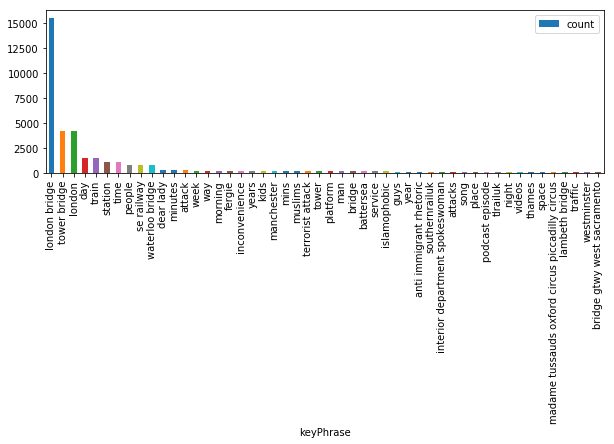

In [83]:
key_phrases_count_dict.iloc[:50,:].plot(
    x="keyPhrase", 
    y="count", 
    kind="bar",
    figsize=(10,3)
)

In [85]:
key_phrases_category_count_2

OrderedDict([('london bridge', 15565),
             ('tower bridge', 4209),
             ('london', 4171),
             ('day', 1507),
             ('train', 1502),
             ('station', 1092),
             ('time', 1069),
             ('people', 814),
             ('se railway', 789),
             ('waterloo bridge', 778),
             ('dear lady', 319),
             ('minutes', 311),
             ('attack', 290),
             ('week', 238),
             ('way', 232),
             ('morning', 219),
             ('fergie', 210),
             ('inconvenience', 208),
             ('years', 191),
             ('kids', 190),
             ('manchester', 188),
             ('mins', 178),
             ('muslims', 169),
             ('terrorist attack', 168),
             ('tower', 165),
             ('platform', 161),
             ('man', 159),
             ('bridge', 153),
             ('battersea', 147),
             ('service', 145),
             ('islamophobic', 143),
             ('g

In [86]:
def get_short_key_phrases(keyPhrases):
    shorter_phrases = []
    for phrase in keyPhrases:
        if len(phrase.split(" ")) <  5:
            shorter_phrases.append(phrase)
    return shorter_phrases
key_phrases_df["shortKeyPhrases"] = key_phrases_df["keyPhrases"].apply(get_short_key_phrases)

In [87]:
key_phrases_df.id = key_phrases_df.id.astype(int)
tweet_keyPhrases = pd.merge(
    tweets[["index", "text", "processed_text", "count"]], 
    key_phrases_df[["id", "keyPhrases", "shortKeyPhrases"]], 
    left_on="index", 
    right_on="id",
    how="left")

tweet_keyPhrases.sort_values(by=["count"], ascending=[False], inplace=True)
tweet_keyPhrases.to_csv("tweet_keyPhrases.csv")
tweet_keyPhrases.head()

,index,text,processed_text,count,id,keyPhrases,shortKeyPhrases
0,11637,"""LOL I JUST HEARD THE TUBE COORDINATOR (or wha...",lol i just heard the tube coordinator or whate...,2470,11637,"[mic, bolaz, guys, tube coordinator, london br...","[mic, bolaz, guys, tube coordinator, london br..."
1,15277,"""RT @EtniesJags: “London Bridge is falling dow...",rt etniesjags london bridge is falling down my...,1955,15277,"[london bridge, dear lady]","[london bridge, dear lady]"
2,9621,"""For anyone believing that corruption is mainl...",for anyone believing that corruption is mainly...,654,9621,"[man, article, world problem, centre, scandal ...","[man, article, world problem, centre, scandal ..."
3,20342,"""You mean like the 7/7 tube bombers did, the M...",you mean like the 7 7 tube bombers did the mar...,608,20342,"[marchester arena bomber, london bridge, hypoc...","[marchester arena bomber, london bridge, hypoc..."
4,15915,"""RT @kurtnysgvia: Tangina yung grades ko paran...",rt kurtnysgvia tangina yung grades ko parang l...,593,15915,[london bridge],[london bridge]


In [88]:
def exists_in_top_x(top_x, keyPhrases, count):
    if not isinstance(keyPhrases, float):
        for item in top_x:
            if item in keyPhrases:
                return count
    return 0

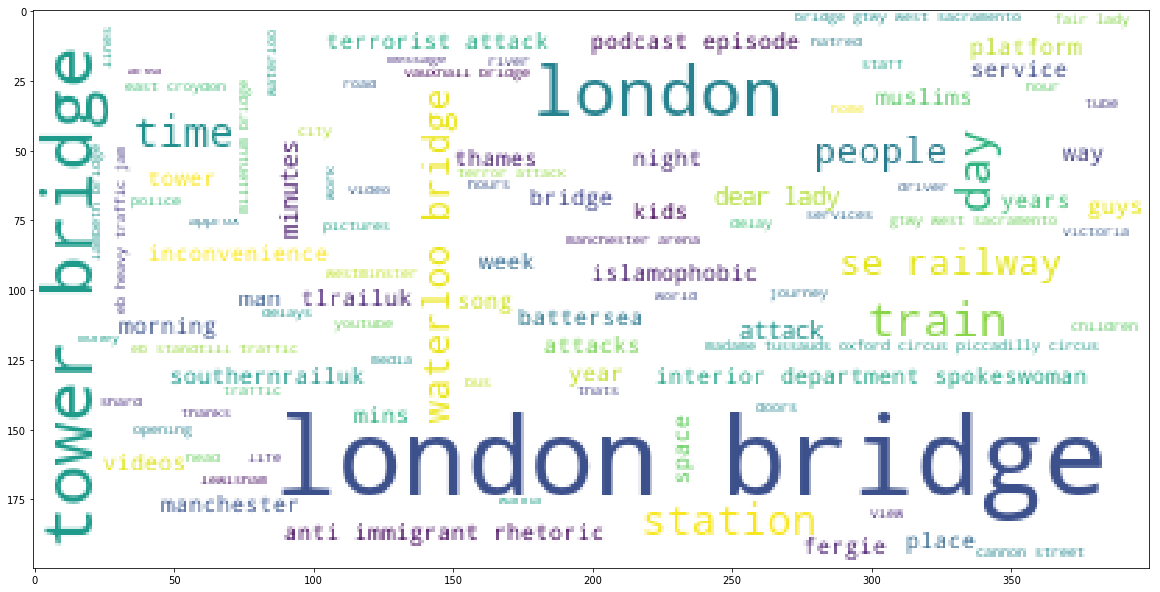

In [89]:
import matplotlib.pyplot as plt

wc = WordCloud(background_color="white",
               max_words=100,
               relative_scaling=0.5,
               normalize_plurals=False).generate_from_frequencies(key_phrases_category_count_2)
plt.figure(figsize=(20,20))
plt.imshow(wc)

__________________________________________________________________________________________________________________